# Lecture 20: Recurrent Neural Networks

![](https://www.tensorflow.org/images/colab_logo_32px.png)
[Run in colab](https://colab.research.google.com/drive/1vb_GwBXbMQwR8Kd0V0LTwvykwJP9FQlI)

In [1]:
import datetime
now = datetime.datetime.now()
print("Version: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Version: 2024-05-14 22:41:54


## This Lecture 

* The basics of RNNs 
* This is a complex and very varied subject (could do a whole course on this alone)
* Will not cover multi-layer RNNs, Very Deep RNNs, GPU optimisation, complex cells 

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
def reset_state(seed=42):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
try:
    import subprocess
    subprocess.run("git config --get remote.origin.url | grep 'astro-informatics'", shell=True, check=True)
    PROJECT_ROOT_DIR = "."
    CHAPTER_ID = "Lecture20_Images"
except: 
    PROJECT_ROOT_DIR = "."
    CHAPTER_ID = ""

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID, fig_id + ".png")
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format='png', dpi=300)
    
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
    
import warnings
warnings.filterwarnings('ignore')

## Overview of RNNs

* General class of network used to predict future outcomes 
* For examle stock prices, trajectories
* Can work on sequences of arbitrary lengths rather than fixed size 
* E.g. documents, audio, sentence construction, sentiment analysis (reviews)




* Until now looked at feedforward networks where activations flow one way 
(* except that training is done used reverse gradient descent) 
* RNNs have connections pointing backward as well 
* Simplest possible case: 

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture20_Images/rnn.jpeg" alt="Drawing" style="width: 500px;"/>

* At each time step (aka frame) neuron recieves input _and_ its own output
* Network is _unrolled_ over time 


* Layer of recurrent neurons, and unrolling over time 

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture20_Images/rnn_layer.jpeg" alt="Drawing" style="width: 900px;"/>



## Memory Cells 

* Since at time step $t$ there is some memory of previous states there is some memory in the system 

* _Memory cell_ is one that preserves state (a very basic cell) 

## Different Types of RNN

Seq to seq (top left), seq to vector (top right), vector to seq (bottom left), delayed seq to seq (bottom right)

- Seq to Seq: each input returns one output
- Seq to Vector: RNN returns one signe output with all the sequential data
- Vector to Seq: take one input and return sequential output (e.g. cat image as input and sentence "This is a cat" as output)
- Delayed Seq to Seq: multiple input return multiple output(e.g. translation)

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture20_Images/seqvec.jpeg" alt="Drawing" style="width: 500px;"/>

Seq-Seq: e.g. stock prices, 
Seq-Vec: e.g. sentiment score, 
Vec-Seq: e.g. caption creation for image, 
Delayed Seq-Seq: e.g. language translation 


## Basic Example with TF

We will create an RNN composed of a layer of five recurrent neurons; using the tanh activation function. We will assume that the RNN runs over only two time steps, taking input vectors of size 3 at each time step.

Making this network, unrolled twice: 

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture20_Images/rnn_layer.jpeg" alt="Drawing" style="width: 500px;"/>

## Training a Squential Classifier  

Similar to normal NN except back propagation is done through time i.e. layer sequential gradients to weights assigned to match output of layers.  

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture20_Images/backprop.jpeg" alt="Drawing" style="width: 500px;"/>

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture20_Images/seqclass.jpeg" alt="Drawing" style="width: 900px;"/>

## Time Series 

* Time series e.g. such as stock prices, air temperature, brain wave patterns, and so on. 
* In this section we will train an RNN to predict the next value in a generated time series. 

### Generate the Dataset

In [13]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    print(series.shape)
    return series[..., np.newaxis].astype(np.float32)

In [14]:
freq1, freq2, offsets1, offsets2 = np.random.rand(4, 1, 1)
freq1, freq2, offsets1, offsets2

(array([[0.53680354]]),
 array([[0.45702764]]),
 array([[0.84214604]]),
 array([[0.47484406]]))

In [15]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

(10000, 51)


In [22]:
print(series.shape)
print(X_valid.shape)
print(y_valid.shape)

(10000, 51, 1)
(2000, 50, 1)
(2000, 1)


In [23]:
X_valid

array([[[-0.3761855 ],
        [-0.42404684],
        [-0.3390344 ],
        ...,
        [ 0.5767727 ],
        [ 0.59239095],
        [ 0.5643068 ]],

       [[-0.2529655 ],
        [-0.24267727],
        [-0.08966523],
        ...,
        [-0.62975067],
        [-0.7007588 ],
        [-0.6759614 ]],

       [[ 0.57377684],
        [ 0.35977325],
        [ 0.06917338],
        ...,
        [ 0.14633761],
        [ 0.42088968],
        [ 0.64214784]],

       ...,

       [[ 0.19489938],
        [ 0.06072497],
        [-0.09699167],
        ...,
        [ 0.14607765],
        [-0.07222243],
        [-0.19055651]],

       [[-0.3360911 ],
        [-0.39338443],
        [-0.4867973 ],
        ...,
        [ 0.22584833],
        [-0.0463774 ],
        [-0.1811238 ]],

       [[ 0.5712927 ],
        [ 0.5462668 ],
        [ 0.3411039 ],
        ...,
        [-0.02652146],
        [ 0.18169478],
        [ 0.42333305]]], dtype=float32)

In [24]:
X_valid[0, :, 0].shape

(50,)

In [25]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

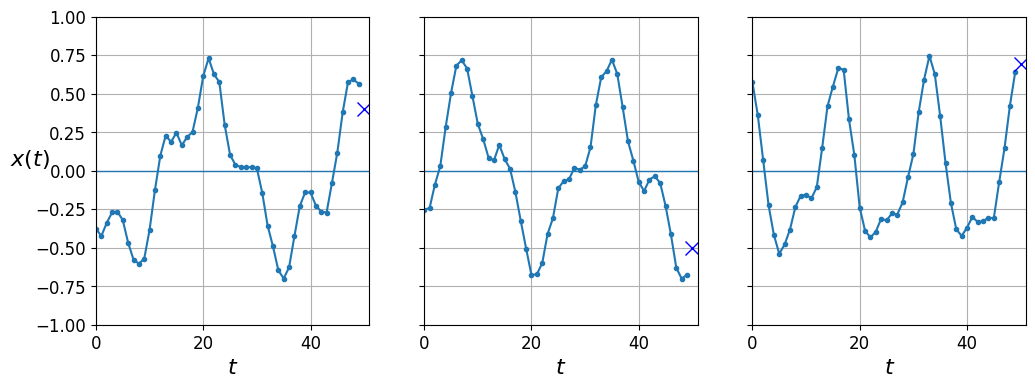

In [26]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [27]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

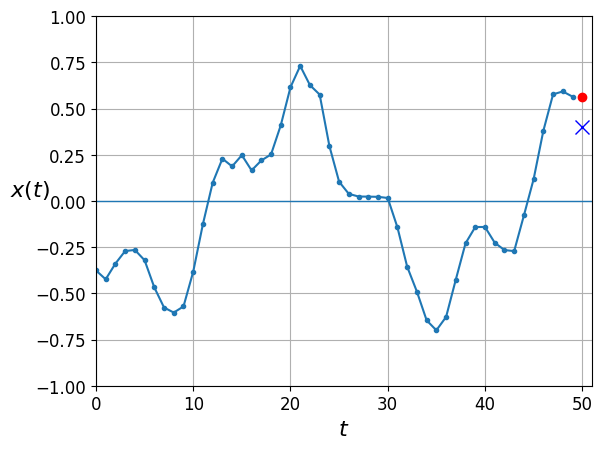

In [28]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")

In [10]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20



  1/219 [..............................] - ETA: 1:05 - loss: 0.3437


 24/219 [==>...........................] - ETA: 1s - loss: 0.2724  


 87/219 [==========>...................] - ETA: 0s - loss: 0.1819


150/219 [===================>..........] - ETA: 0s - loss: 0.1367


210/219 [===========================>..] - ETA: 0s - loss: 0.1154


219/219 [==============================] - 1s 2ms/step - loss: 0.1128 - val_loss: 0.0565


Epoch 2/20



  1/219 [..............................] - ETA: 0s - loss: 0.0492


 62/219 [=======>......................] - ETA: 0s - loss: 0.0491


124/219 [===============>..............] - ETA: 0s - loss: 0.0457


187/219 [========================>.....] - ETA: 0s - loss: 0.0425


219/219 [==============================] - 0s 1ms/step - loss: 0.0413 - val_loss: 0.0324


Epoch 3/20



  1/219 [..............................] - ETA: 0s - loss: 0.0303


 62/219 [=======>......................] - ETA: 0s - loss: 0.0310


123/219 [===============>..............] - ETA: 0s - loss: 0.0286


184/219 [========================>.....] - ETA: 0s - loss: 0.0265


219/219 [==============================] - 0s 1ms/step - loss: 0.0255 - val_loss: 0.0216


Epoch 4/20



  1/219 [..............................] - ETA: 0s - loss: 0.0253


 62/219 [=======>......................] - ETA: 0s - loss: 0.0207


124/219 [===============>..............] - ETA: 0s - loss: 0.0192


185/219 [========================>.....] - ETA: 0s - loss: 0.0184


219/219 [==============================] - 0s 1ms/step - loss: 0.0183 - val_loss: 0.0169


Epoch 5/20



  1/219 [..............................] - ETA: 0s - loss: 0.0207


 63/219 [=======>......................] - ETA: 0s - loss: 0.0158


124/219 [===============>..............] - ETA: 0s - loss: 0.0152


187/219 [========================>.....] - ETA: 0s - loss: 0.0149


219/219 [==============================] - 0s 1ms/step - loss: 0.0146 - val_loss: 0.0142


Epoch 6/20



  1/219 [..............................] - ETA: 0s - loss: 0.0145


 59/219 [=======>......................] - ETA: 0s - loss: 0.0135


111/219 [==============>...............] - ETA: 0s - loss: 0.0131


173/219 [======================>.......] - ETA: 0s - loss: 0.0126


219/219 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 0.0124


Epoch 7/20



  1/219 [..............................] - ETA: 0s - loss: 0.0109


 63/219 [=======>......................] - ETA: 0s - loss: 0.0114


124/219 [===============>..............] - ETA: 0s - loss: 0.0111


187/219 [========================>.....] - ETA: 0s - loss: 0.0109


219/219 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0108


Epoch 8/20



  1/219 [..............................] - ETA: 0s - loss: 0.0123


 63/219 [=======>......................] - ETA: 0s - loss: 0.0098


124/219 [===============>..............] - ETA: 0s - loss: 0.0096


188/219 [========================>.....] - ETA: 0s - loss: 0.0096


219/219 [==============================] - 0s 1ms/step - loss: 0.0095 - val_loss: 0.0094


Epoch 9/20



  1/219 [..............................] - ETA: 0s - loss: 0.0100


 64/219 [=======>......................] - ETA: 0s - loss: 0.0086


127/219 [================>.............] - ETA: 0s - loss: 0.0084


190/219 [=========================>....] - ETA: 0s - loss: 0.0084


219/219 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0083


Epoch 10/20



  1/219 [..............................] - ETA: 0s - loss: 0.0058


 63/219 [=======>......................] - ETA: 0s - loss: 0.0078


126/219 [================>.............] - ETA: 0s - loss: 0.0078


187/219 [========================>.....] - ETA: 0s - loss: 0.0076


219/219 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0075


Epoch 11/20



  1/219 [..............................] - ETA: 0s - loss: 0.0072


 63/219 [=======>......................] - ETA: 0s - loss: 0.0070


125/219 [================>.............] - ETA: 0s - loss: 0.0069


188/219 [========================>.....] - ETA: 0s - loss: 0.0068


219/219 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0067


Epoch 12/20



  1/219 [..............................] - ETA: 0s - loss: 0.0075


 63/219 [=======>......................] - ETA: 0s - loss: 0.0060


127/219 [================>.............] - ETA: 0s - loss: 0.0060


190/219 [=========================>....] - ETA: 0s - loss: 0.0061


219/219 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0063


Epoch 13/20



  1/219 [..............................] - ETA: 0s - loss: 0.0061


 65/219 [=======>......................] - ETA: 0s - loss: 0.0057


126/219 [================>.............] - ETA: 0s - loss: 0.0056


189/219 [========================>.....] - ETA: 0s - loss: 0.0057


219/219 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0057


Epoch 14/20



  1/219 [..............................] - ETA: 0s - loss: 0.0047


 63/219 [=======>......................] - ETA: 0s - loss: 0.0054


125/219 [================>.............] - ETA: 0s - loss: 0.0055


186/219 [========================>.....] - ETA: 0s - loss: 0.0054


219/219 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0053


Epoch 15/20



  1/219 [..............................] - ETA: 0s - loss: 0.0041


 64/219 [=======>......................] - ETA: 0s - loss: 0.0051


125/219 [================>.............] - ETA: 0s - loss: 0.0051


188/219 [========================>.....] - ETA: 0s - loss: 0.0051


219/219 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0051


Epoch 16/20



  1/219 [..............................] - ETA: 0s - loss: 0.0038


 63/219 [=======>......................] - ETA: 0s - loss: 0.0048


127/219 [================>.............] - ETA: 0s - loss: 0.0048


191/219 [=========================>....] - ETA: 0s - loss: 0.0048


219/219 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0051


Epoch 17/20



  1/219 [..............................] - ETA: 0s - loss: 0.0059


 65/219 [=======>......................] - ETA: 0s - loss: 0.0048


129/219 [================>.............] - ETA: 0s - loss: 0.0048


194/219 [=========================>....] - ETA: 0s - loss: 0.0047


219/219 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0047


Epoch 18/20



  1/219 [..............................] - ETA: 0s - loss: 0.0039


 62/219 [=======>......................] - ETA: 0s - loss: 0.0045


126/219 [================>.............] - ETA: 0s - loss: 0.0046


186/219 [========================>.....] - ETA: 0s - loss: 0.0045


219/219 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0046


Epoch 19/20



  1/219 [..............................] - ETA: 0s - loss: 0.0060


 64/219 [=======>......................] - ETA: 0s - loss: 0.0044


125/219 [================>.............] - ETA: 0s - loss: 0.0044


187/219 [========================>.....] - ETA: 0s - loss: 0.0045


219/219 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0045


Epoch 20/20



  1/219 [..............................] - ETA: 0s - loss: 0.0050


 61/219 [=======>......................] - ETA: 0s - loss: 0.0046


124/219 [===============>..............] - ETA: 0s - loss: 0.0044


186/219 [========================>.....] - ETA: 0s - loss: 0.0043


219/219 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0043


In [11]:
model.evaluate(X_valid, y_valid)


 1/63 [..............................] - ETA: 1s - loss: 0.0035


63/63 [==============================] - 0s 770us/step - loss: 0.0043


0.004332945682108402

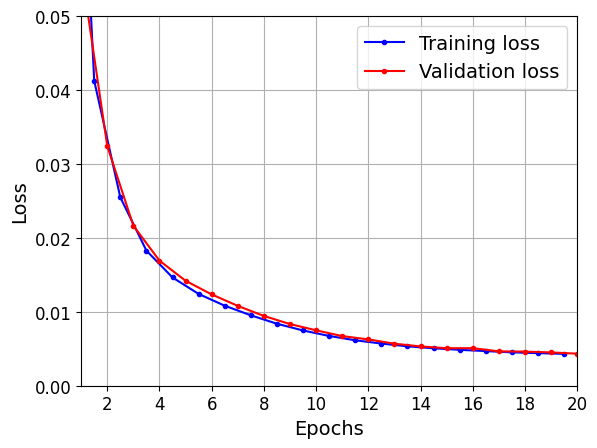

In [12]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()


 1/63 [..............................] - ETA: 3s


63/63 [==============================] - 0s 675us/step


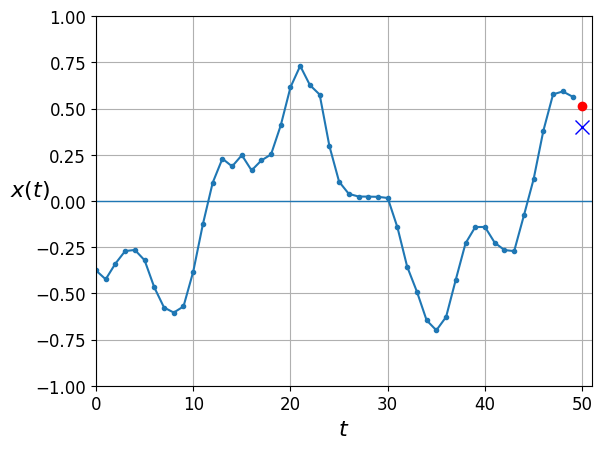

In [13]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.legacy.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)

In [15]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10



  1/219 [..............................] - ETA: 2:03 - loss: 0.7257


 13/219 [>.............................] - ETA: 0s - loss: 0.6183  


 25/219 [==>...........................] - ETA: 0s - loss: 0.5829


 37/219 [====>.........................] - ETA: 0s - loss: 0.5394


 49/219 [=====>........................] - ETA: 0s - loss: 0.4943


 62/219 [=======>......................] - ETA: 0s - loss: 0.4500


 75/219 [=========>....................] - ETA: 0s - loss: 0.4197


 88/219 [===========>..................] - ETA: 0s - loss: 0.3991


100/219 [============>.................] - ETA: 0s - loss: 0.3802


113/219 [==============>...............] - ETA: 0s - loss: 0.3670


126/219 [================>.............] - ETA: 0s - loss: 0.3546


139/219 [==================>...........] - ETA: 0s - loss: 0.3438


152/219 [===================>..........] - ETA: 0s - loss: 0.3338


165/219 [=====================>........] - ETA: 0s - loss: 0.3237


177/219 [=======================>......] - ETA: 0s - loss: 0.3152


190/219 [=========================>....] - ETA: 0s - loss: 0.3048


203/219 [==========================>...] - ETA: 0s - loss: 0.2960


216/219 [============================>.] - ETA: 0s - loss: 0.2883


219/219 [==============================] - 2s 5ms/step - loss: 0.2864 - val_loss: 0.1554


Epoch 2/10



  1/219 [..............................] - ETA: 1s - loss: 0.1384


 14/219 [>.............................] - ETA: 0s - loss: 0.1488


 27/219 [==>...........................] - ETA: 0s - loss: 0.1553


 40/219 [====>.........................] - ETA: 0s - loss: 0.1534


 52/219 [======>.......................] - ETA: 0s - loss: 0.1524


 64/219 [=======>......................] - ETA: 0s - loss: 0.1495


 77/219 [=========>....................] - ETA: 0s - loss: 0.1500


 90/219 [===========>..................] - ETA: 0s - loss: 0.1491


103/219 [=============>................] - ETA: 0s - loss: 0.1488


116/219 [==============>...............] - ETA: 0s - loss: 0.1493


129/219 [================>.............] - ETA: 0s - loss: 0.1497


141/219 [==================>...........] - ETA: 0s - loss: 0.1503


152/219 [===================>..........] - ETA: 0s - loss: 0.1499


163/219 [=====================>........] - ETA: 0s - loss: 0.1494


176/219 [=======================>......] - ETA: 0s - loss: 0.1490


188/219 [========================>.....] - ETA: 0s - loss: 0.1487


201/219 [==========================>...] - ETA: 0s - loss: 0.1481


212/219 [============================>.] - ETA: 0s - loss: 0.1487


219/219 [==============================] - 1s 5ms/step - loss: 0.1486 - val_loss: 0.1516


Epoch 3/10



  1/219 [..............................] - ETA: 1s - loss: 0.1495


 14/219 [>.............................] - ETA: 0s - loss: 0.1470


 27/219 [==>...........................] - ETA: 0s - loss: 0.1478


 39/219 [====>.........................] - ETA: 0s - loss: 0.1471


 52/219 [======>.......................] - ETA: 0s - loss: 0.1491


 64/219 [=======>......................] - ETA: 0s - loss: 0.1479


 76/219 [=========>....................] - ETA: 0s - loss: 0.1474


 88/219 [===========>..................] - ETA: 0s - loss: 0.1473


100/219 [============>.................] - ETA: 0s - loss: 0.1466


112/219 [==============>...............] - ETA: 0s - loss: 0.1479


124/219 [===============>..............] - ETA: 0s - loss: 0.1476


137/219 [=================>............] - ETA: 0s - loss: 0.1461


150/219 [===================>..........] - ETA: 0s - loss: 0.1454


162/219 [=====================>........] - ETA: 0s - loss: 0.1455


175/219 [======================>.......] - ETA: 0s - loss: 0.1456


188/219 [========================>.....] - ETA: 0s - loss: 0.1461


201/219 [==========================>...] - ETA: 0s - loss: 0.1464


214/219 [============================>.] - ETA: 0s - loss: 0.1463


219/219 [==============================] - 1s 5ms/step - loss: 0.1462 - val_loss: 0.1570


Epoch 4/10



  1/219 [..............................] - ETA: 1s - loss: 0.1555


 14/219 [>.............................] - ETA: 0s - loss: 0.1553


 26/219 [==>...........................] - ETA: 0s - loss: 0.1583


 39/219 [====>.........................] - ETA: 0s - loss: 0.1525


 51/219 [=====>........................] - ETA: 0s - loss: 0.1537


 63/219 [=======>......................] - ETA: 0s - loss: 0.1521


 75/219 [=========>....................] - ETA: 0s - loss: 0.1494


 87/219 [==========>...................] - ETA: 0s - loss: 0.1514


100/219 [============>.................] - ETA: 0s - loss: 0.1516


113/219 [==============>...............] - ETA: 0s - loss: 0.1524


125/219 [================>.............] - ETA: 0s - loss: 0.1514


138/219 [=================>............] - ETA: 0s - loss: 0.1506


151/219 [===================>..........] - ETA: 0s - loss: 0.1494


164/219 [=====================>........] - ETA: 0s - loss: 0.1481


177/219 [=======================>......] - ETA: 0s - loss: 0.1473


190/219 [=========================>....] - ETA: 0s - loss: 0.1472


203/219 [==========================>...] - ETA: 0s - loss: 0.1476


216/219 [============================>.] - ETA: 0s - loss: 0.1472


219/219 [==============================] - 1s 5ms/step - loss: 0.1470 - val_loss: 0.1490


Epoch 5/10



  1/219 [..............................] - ETA: 1s - loss: 0.2070


 14/219 [>.............................] - ETA: 0s - loss: 0.1485


 27/219 [==>...........................] - ETA: 0s - loss: 0.1496


 40/219 [====>.........................] - ETA: 0s - loss: 0.1476


 53/219 [======>.......................] - ETA: 0s - loss: 0.1496


 65/219 [=======>......................] - ETA: 0s - loss: 0.1488


 77/219 [=========>....................] - ETA: 0s - loss: 0.1500


 89/219 [===========>..................] - ETA: 0s - loss: 0.1506


101/219 [============>.................] - ETA: 0s - loss: 0.1502


113/219 [==============>...............] - ETA: 0s - loss: 0.1476


126/219 [================>.............] - ETA: 0s - loss: 0.1485


138/219 [=================>............] - ETA: 0s - loss: 0.1478


150/219 [===================>..........] - ETA: 0s - loss: 0.1474


162/219 [=====================>........] - ETA: 0s - loss: 0.1470


174/219 [======================>.......] - ETA: 0s - loss: 0.1478


187/219 [========================>.....] - ETA: 0s - loss: 0.1476


199/219 [==========================>...] - ETA: 0s - loss: 0.1467


212/219 [============================>.] - ETA: 0s - loss: 0.1467


219/219 [==============================] - 1s 5ms/step - loss: 0.1463 - val_loss: 0.1385


Epoch 6/10



  1/219 [..............................] - ETA: 1s - loss: 0.1336


 14/219 [>.............................] - ETA: 0s - loss: 0.1343


 26/219 [==>...........................] - ETA: 0s - loss: 0.1272


 38/219 [====>.........................] - ETA: 0s - loss: 0.1218


 50/219 [=====>........................] - ETA: 0s - loss: 0.1156


 62/219 [=======>......................] - ETA: 0s - loss: 0.1102


 74/219 [=========>....................] - ETA: 0s - loss: 0.1066


 86/219 [==========>...................] - ETA: 0s - loss: 0.1022


 98/219 [============>.................] - ETA: 0s - loss: 0.0991


111/219 [==============>...............] - ETA: 0s - loss: 0.0957


123/219 [===============>..............] - ETA: 0s - loss: 0.0932


135/219 [=================>............] - ETA: 0s - loss: 0.0908


148/219 [===================>..........] - ETA: 0s - loss: 0.0883


160/219 [====================>.........] - ETA: 0s - loss: 0.0864


172/219 [======================>.......] - ETA: 0s - loss: 0.0845


184/219 [========================>.....] - ETA: 0s - loss: 0.0826


197/219 [=========================>....] - ETA: 0s - loss: 0.0807


210/219 [===========================>..] - ETA: 0s - loss: 0.0788


219/219 [==============================] - 1s 5ms/step - loss: 0.0777 - val_loss: 0.0499


Epoch 7/10



  1/219 [..............................] - ETA: 1s - loss: 0.0448


 13/219 [>.............................] - ETA: 0s - loss: 0.0494


 26/219 [==>...........................] - ETA: 0s - loss: 0.0496


 38/219 [====>.........................] - ETA: 0s - loss: 0.0473


 51/219 [=====>........................] - ETA: 0s - loss: 0.0464


 64/219 [=======>......................] - ETA: 0s - loss: 0.0461


 77/219 [=========>....................] - ETA: 0s - loss: 0.0456


 90/219 [===========>..................] - ETA: 0s - loss: 0.0448


103/219 [=============>................] - ETA: 0s - loss: 0.0440


116/219 [==============>...............] - ETA: 0s - loss: 0.0430


128/219 [================>.............] - ETA: 0s - loss: 0.0429


141/219 [==================>...........] - ETA: 0s - loss: 0.0421


153/219 [===================>..........] - ETA: 0s - loss: 0.0415


165/219 [=====================>........] - ETA: 0s - loss: 0.0411


178/219 [=======================>......] - ETA: 0s - loss: 0.0405


191/219 [=========================>....] - ETA: 0s - loss: 0.0399


204/219 [==========================>...] - ETA: 0s - loss: 0.0396


216/219 [============================>.] - ETA: 0s - loss: 0.0393


219/219 [==============================] - 1s 5ms/step - loss: 0.0392 - val_loss: 0.0334


Epoch 8/10



  1/219 [..............................] - ETA: 1s - loss: 0.0239


 13/219 [>.............................] - ETA: 0s - loss: 0.0324


 25/219 [==>...........................] - ETA: 0s - loss: 0.0319


 38/219 [====>.........................] - ETA: 0s - loss: 0.0315


 50/219 [=====>........................] - ETA: 0s - loss: 0.0310


 62/219 [=======>......................] - ETA: 0s - loss: 0.0306


 74/219 [=========>....................] - ETA: 0s - loss: 0.0308


 86/219 [==========>...................] - ETA: 0s - loss: 0.0305


 99/219 [============>.................] - ETA: 0s - loss: 0.0303


112/219 [==============>...............] - ETA: 0s - loss: 0.0303


125/219 [================>.............] - ETA: 0s - loss: 0.0302


138/219 [=================>............] - ETA: 0s - loss: 0.0302


151/219 [===================>..........] - ETA: 0s - loss: 0.0300


163/219 [=====================>........] - ETA: 0s - loss: 0.0298


176/219 [=======================>......] - ETA: 0s - loss: 0.0297


189/219 [========================>.....] - ETA: 0s - loss: 0.0295


202/219 [==========================>...] - ETA: 0s - loss: 0.0293


215/219 [============================>.] - ETA: 0s - loss: 0.0290


219/219 [==============================] - 1s 5ms/step - loss: 0.0289 - val_loss: 0.0260


Epoch 9/10



  1/219 [..............................] - ETA: 1s - loss: 0.0209


 13/219 [>.............................] - ETA: 0s - loss: 0.0224


 25/219 [==>...........................] - ETA: 0s - loss: 0.0243


 38/219 [====>.........................] - ETA: 0s - loss: 0.0245


 51/219 [=====>........................] - ETA: 0s - loss: 0.0252


 63/219 [=======>......................] - ETA: 0s - loss: 0.0251


 76/219 [=========>....................] - ETA: 0s - loss: 0.0248


 88/219 [===========>..................] - ETA: 0s - loss: 0.0248


101/219 [============>.................] - ETA: 0s - loss: 0.0246


114/219 [==============>...............] - ETA: 0s - loss: 0.0245


126/219 [================>.............] - ETA: 0s - loss: 0.0243


139/219 [==================>...........] - ETA: 0s - loss: 0.0245


152/219 [===================>..........] - ETA: 0s - loss: 0.0244


165/219 [=====================>........] - ETA: 0s - loss: 0.0241


177/219 [=======================>......] - ETA: 0s - loss: 0.0240


190/219 [=========================>....] - ETA: 0s - loss: 0.0240


202/219 [==========================>...] - ETA: 0s - loss: 0.0239


215/219 [============================>.] - ETA: 0s - loss: 0.0237


219/219 [==============================] - 1s 5ms/step - loss: 0.0236 - val_loss: 0.0217


Epoch 10/10



  1/219 [..............................] - ETA: 1s - loss: 0.0125


 13/219 [>.............................] - ETA: 0s - loss: 0.0223


 25/219 [==>...........................] - ETA: 0s - loss: 0.0216


 37/219 [====>.........................] - ETA: 0s - loss: 0.0216


 50/219 [=====>........................] - ETA: 0s - loss: 0.0215


 62/219 [=======>......................] - ETA: 0s - loss: 0.0213


 75/219 [=========>....................] - ETA: 0s - loss: 0.0211


 87/219 [==========>...................] - ETA: 0s - loss: 0.0211


100/219 [============>.................] - ETA: 0s - loss: 0.0211


112/219 [==============>...............] - ETA: 0s - loss: 0.0208


125/219 [================>.............] - ETA: 0s - loss: 0.0207


138/219 [=================>............] - ETA: 0s - loss: 0.0206


150/219 [===================>..........] - ETA: 0s - loss: 0.0206


162/219 [=====================>........] - ETA: 0s - loss: 0.0205


175/219 [======================>.......] - ETA: 0s - loss: 0.0206


187/219 [========================>.....] - ETA: 0s - loss: 0.0204


200/219 [==========================>...] - ETA: 0s - loss: 0.0204


212/219 [============================>.] - ETA: 0s - loss: 0.0203


219/219 [==============================] - 1s 5ms/step - loss: 0.0203 - val_loss: 0.0189


In [16]:
model.evaluate(X_valid, y_valid)


 1/63 [..............................] - ETA: 1s - loss: 0.0203


27/63 [===========>..................] - ETA: 0s - loss: 0.0190


55/63 [=========================>....] - ETA: 0s - loss: 0.0189


63/63 [==============================] - 0s 2ms/step - loss: 0.0189


0.01888158917427063

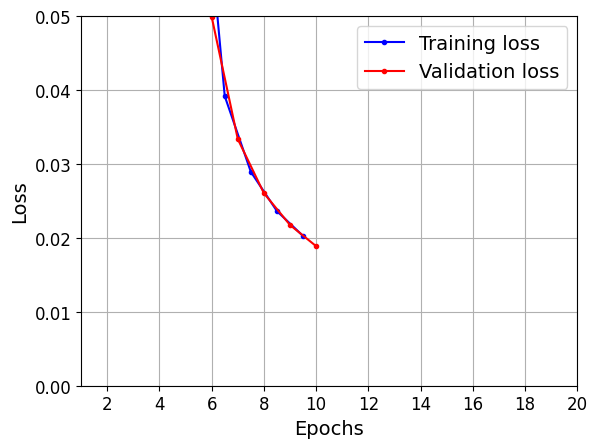

In [17]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()


 1/63 [..............................] - ETA: 6s


29/63 [============>.................] - ETA: 0s


58/63 [==========================>...] - ETA: 0s


63/63 [==============================] - 0s 2ms/step


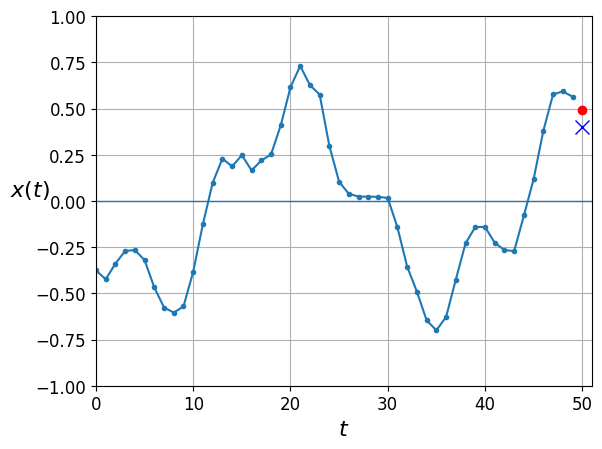

In [18]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

### Very simple multi-cell example 

* Can also have multiple cells per time step - defining a deep RNNS 
* Built by stacking cells into a MultiRNNCell().
* Subject gets very complex very fast - will keep it simple 


<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture20_Images/deeprnn.jpeg" alt="Drawing" style="width: 500px;"/>


In [19]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

optimizer = keras.optimizers.legacy.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)

In [20]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10



  1/219 [..............................] - ETA: 5:24 - loss: 0.3275


  5/219 [..............................] - ETA: 3s - loss: 0.1581  


  9/219 [>.............................] - ETA: 2s - loss: 0.1111


 13/219 [>.............................] - ETA: 2s - loss: 0.0884


 17/219 [=>............................] - ETA: 2s - loss: 0.0724


 21/219 [=>............................] - ETA: 2s - loss: 0.0620


 25/219 [==>...........................] - ETA: 2s - loss: 0.0540


 29/219 [==>...........................] - ETA: 2s - loss: 0.0483


 33/219 [===>..........................] - ETA: 2s - loss: 0.0438


 37/219 [====>.........................] - ETA: 2s - loss: 0.0399


 41/219 [====>.........................] - ETA: 2s - loss: 0.0368


 45/219 [=====>........................] - ETA: 2s - loss: 0.0341


 49/219 [=====>........................] - ETA: 2s - loss: 0.0318


 53/219 [======>.......................] - ETA: 2s - loss: 0.0298


 57/219 [======>.......................] - ETA: 2s - loss: 0.0281


 61/219 [=======>......................] - ETA: 2s - loss: 0.0267


 65/219 [=======>......................] - ETA: 2s - loss: 0.0254


 69/219 [========>.....................] - ETA: 2s - loss: 0.0242


 73/219 [=========>....................] - ETA: 1s - loss: 0.0231


 77/219 [=========>....................] - ETA: 1s - loss: 0.0222


 81/219 [==========>...................] - ETA: 1s - loss: 0.0214


 85/219 [==========>...................] - ETA: 1s - loss: 0.0207


 89/219 [===========>..................] - ETA: 1s - loss: 0.0200


 93/219 [===========>..................] - ETA: 1s - loss: 0.0194


 97/219 [============>.................] - ETA: 1s - loss: 0.0188


101/219 [============>.................] - ETA: 1s - loss: 0.0183


105/219 [=============>................] - ETA: 1s - loss: 0.0178


109/219 [=============>................] - ETA: 1s - loss: 0.0173


113/219 [==============>...............] - ETA: 1s - loss: 0.0169


117/219 [===============>..............] - ETA: 1s - loss: 0.0166


121/219 [===============>..............] - ETA: 1s - loss: 0.0162


125/219 [================>.............] - ETA: 1s - loss: 0.0159


129/219 [================>.............] - ETA: 1s - loss: 0.0156


133/219 [=================>............] - ETA: 1s - loss: 0.0153


137/219 [=================>............] - ETA: 1s - loss: 0.0150


141/219 [==================>...........] - ETA: 1s - loss: 0.0147


145/219 [==================>...........] - ETA: 1s - loss: 0.0145


149/219 [===================>..........] - ETA: 0s - loss: 0.0142


153/219 [===================>..........] - ETA: 0s - loss: 0.0139


157/219 [====================>.........] - ETA: 0s - loss: 0.0137


161/219 [=====================>........] - ETA: 0s - loss: 0.0135


165/219 [=====================>........] - ETA: 0s - loss: 0.0133


169/219 [======================>.......] - ETA: 0s - loss: 0.0131


173/219 [======================>.......] - ETA: 0s - loss: 0.0129


177/219 [=======================>......] - ETA: 0s - loss: 0.0127


181/219 [=======================>......] - ETA: 0s - loss: 0.0125


185/219 [========================>.....] - ETA: 0s - loss: 0.0123


189/219 [========================>.....] - ETA: 0s - loss: 0.0121


193/219 [=========================>....] - ETA: 0s - loss: 0.0120


197/219 [=========================>....] - ETA: 0s - loss: 0.0118


201/219 [==========================>...] - ETA: 0s - loss: 0.0117


205/219 [===========================>..] - ETA: 0s - loss: 0.0115


209/219 [===========================>..] - ETA: 0s - loss: 0.0114


213/219 [============================>.] - ETA: 0s - loss: 0.0113


217/219 [============================>.] - ETA: 0s - loss: 0.0112


219/219 [==============================] - 5s 16ms/step - loss: 0.0111 - val_loss: 0.0041


Epoch 2/10



  1/219 [..............................] - ETA: 3s - loss: 0.0052


  5/219 [..............................] - ETA: 2s - loss: 0.0044


  9/219 [>.............................] - ETA: 2s - loss: 0.0043


 13/219 [>.............................] - ETA: 2s - loss: 0.0044


 17/219 [=>............................] - ETA: 2s - loss: 0.0044


 21/219 [=>............................] - ETA: 2s - loss: 0.0046


 25/219 [==>...........................] - ETA: 2s - loss: 0.0044


 29/219 [==>...........................] - ETA: 2s - loss: 0.0043


 33/219 [===>..........................] - ETA: 2s - loss: 0.0043


 37/219 [====>.........................] - ETA: 2s - loss: 0.0044


 41/219 [====>.........................] - ETA: 2s - loss: 0.0044


 45/219 [=====>........................] - ETA: 2s - loss: 0.0045


 49/219 [=====>........................] - ETA: 2s - loss: 0.0045


 53/219 [======>.......................] - ETA: 2s - loss: 0.0044


 57/219 [======>.......................] - ETA: 2s - loss: 0.0044


 61/219 [=======>......................] - ETA: 2s - loss: 0.0045


 65/219 [=======>......................] - ETA: 2s - loss: 0.0045


 69/219 [========>.....................] - ETA: 2s - loss: 0.0045


 73/219 [=========>....................] - ETA: 2s - loss: 0.0045


 77/219 [=========>....................] - ETA: 1s - loss: 0.0045


 81/219 [==========>...................] - ETA: 1s - loss: 0.0045


 85/219 [==========>...................] - ETA: 1s - loss: 0.0046


 89/219 [===========>..................] - ETA: 1s - loss: 0.0046


 93/219 [===========>..................] - ETA: 1s - loss: 0.0046


 97/219 [============>.................] - ETA: 1s - loss: 0.0046


101/219 [============>.................] - ETA: 1s - loss: 0.0046


105/219 [=============>................] - ETA: 1s - loss: 0.0046


109/219 [=============>................] - ETA: 1s - loss: 0.0046


113/219 [==============>...............] - ETA: 1s - loss: 0.0046


117/219 [===============>..............] - ETA: 1s - loss: 0.0046


121/219 [===============>..............] - ETA: 1s - loss: 0.0046


125/219 [================>.............] - ETA: 1s - loss: 0.0046


129/219 [================>.............] - ETA: 1s - loss: 0.0046


133/219 [=================>............] - ETA: 1s - loss: 0.0046


137/219 [=================>............] - ETA: 1s - loss: 0.0046


141/219 [==================>...........] - ETA: 1s - loss: 0.0046


145/219 [==================>...........] - ETA: 1s - loss: 0.0046


149/219 [===================>..........] - ETA: 0s - loss: 0.0046


153/219 [===================>..........] - ETA: 0s - loss: 0.0046


157/219 [====================>.........] - ETA: 0s - loss: 0.0046


161/219 [=====================>........] - ETA: 0s - loss: 0.0046


165/219 [=====================>........] - ETA: 0s - loss: 0.0046


169/219 [======================>.......] - ETA: 0s - loss: 0.0046


173/219 [======================>.......] - ETA: 0s - loss: 0.0047


177/219 [=======================>......] - ETA: 0s - loss: 0.0047


181/219 [=======================>......] - ETA: 0s - loss: 0.0047


185/219 [========================>.....] - ETA: 0s - loss: 0.0047


189/219 [========================>.....] - ETA: 0s - loss: 0.0047


193/219 [=========================>....] - ETA: 0s - loss: 0.0047


197/219 [=========================>....] - ETA: 0s - loss: 0.0047


201/219 [==========================>...] - ETA: 0s - loss: 0.0048


205/219 [===========================>..] - ETA: 0s - loss: 0.0048


209/219 [===========================>..] - ETA: 0s - loss: 0.0047


213/219 [============================>.] - ETA: 0s - loss: 0.0048


217/219 [============================>.] - ETA: 0s - loss: 0.0048


219/219 [==============================] - 3s 15ms/step - loss: 0.0047 - val_loss: 0.0046


Epoch 3/10



  1/219 [..............................] - ETA: 3s - loss: 0.0061


  5/219 [..............................] - ETA: 3s - loss: 0.0047


  9/219 [>.............................] - ETA: 2s - loss: 0.0043


 13/219 [>.............................] - ETA: 2s - loss: 0.0042


 17/219 [=>............................] - ETA: 2s - loss: 0.0043


 21/219 [=>............................] - ETA: 2s - loss: 0.0043


 25/219 [==>...........................] - ETA: 2s - loss: 0.0042


 29/219 [==>...........................] - ETA: 2s - loss: 0.0042


 33/219 [===>..........................] - ETA: 2s - loss: 0.0042


 37/219 [====>.........................] - ETA: 2s - loss: 0.0043


 41/219 [====>.........................] - ETA: 2s - loss: 0.0043


 45/219 [=====>........................] - ETA: 2s - loss: 0.0043


 49/219 [=====>........................] - ETA: 2s - loss: 0.0043


 53/219 [======>.......................] - ETA: 2s - loss: 0.0043


 57/219 [======>.......................] - ETA: 2s - loss: 0.0043


 61/219 [=======>......................] - ETA: 2s - loss: 0.0043


 65/219 [=======>......................] - ETA: 2s - loss: 0.0042


 69/219 [========>.....................] - ETA: 2s - loss: 0.0043


 73/219 [=========>....................] - ETA: 2s - loss: 0.0043


 77/219 [=========>....................] - ETA: 1s - loss: 0.0043


 81/219 [==========>...................] - ETA: 1s - loss: 0.0043


 85/219 [==========>...................] - ETA: 1s - loss: 0.0044


 89/219 [===========>..................] - ETA: 1s - loss: 0.0043


 93/219 [===========>..................] - ETA: 1s - loss: 0.0043


 97/219 [============>.................] - ETA: 1s - loss: 0.0043


101/219 [============>.................] - ETA: 1s - loss: 0.0043


105/219 [=============>................] - ETA: 1s - loss: 0.0043


109/219 [=============>................] - ETA: 1s - loss: 0.0043


113/219 [==============>...............] - ETA: 1s - loss: 0.0043


117/219 [===============>..............] - ETA: 1s - loss: 0.0043


121/219 [===============>..............] - ETA: 1s - loss: 0.0043


125/219 [================>.............] - ETA: 1s - loss: 0.0042


129/219 [================>.............] - ETA: 1s - loss: 0.0042


133/219 [=================>............] - ETA: 1s - loss: 0.0042


137/219 [=================>............] - ETA: 1s - loss: 0.0042


141/219 [==================>...........] - ETA: 1s - loss: 0.0042


145/219 [==================>...........] - ETA: 1s - loss: 0.0042


149/219 [===================>..........] - ETA: 0s - loss: 0.0043


153/219 [===================>..........] - ETA: 0s - loss: 0.0043


157/219 [====================>.........] - ETA: 0s - loss: 0.0043


161/219 [=====================>........] - ETA: 0s - loss: 0.0043


165/219 [=====================>........] - ETA: 0s - loss: 0.0043


169/219 [======================>.......] - ETA: 0s - loss: 0.0043


173/219 [======================>.......] - ETA: 0s - loss: 0.0043


177/219 [=======================>......] - ETA: 0s - loss: 0.0043


181/219 [=======================>......] - ETA: 0s - loss: 0.0043


185/219 [========================>.....] - ETA: 0s - loss: 0.0043


189/219 [========================>.....] - ETA: 0s - loss: 0.0043


193/219 [=========================>....] - ETA: 0s - loss: 0.0043


197/219 [=========================>....] - ETA: 0s - loss: 0.0042


201/219 [==========================>...] - ETA: 0s - loss: 0.0042


205/219 [===========================>..] - ETA: 0s - loss: 0.0042


209/219 [===========================>..] - ETA: 0s - loss: 0.0042


213/219 [============================>.] - ETA: 0s - loss: 0.0042


217/219 [============================>.] - ETA: 0s - loss: 0.0042


219/219 [==============================] - 3s 15ms/step - loss: 0.0042 - val_loss: 0.0035


Epoch 4/10



  1/219 [..............................] - ETA: 3s - loss: 0.0035


  5/219 [..............................] - ETA: 2s - loss: 0.0030


  9/219 [>.............................] - ETA: 2s - loss: 0.0037


 13/219 [>.............................] - ETA: 2s - loss: 0.0036


 17/219 [=>............................] - ETA: 2s - loss: 0.0036


 21/219 [=>............................] - ETA: 2s - loss: 0.0037


 25/219 [==>...........................] - ETA: 2s - loss: 0.0037


 29/219 [==>...........................] - ETA: 2s - loss: 0.0038


 33/219 [===>..........................] - ETA: 2s - loss: 0.0039


 37/219 [====>.........................] - ETA: 2s - loss: 0.0039


 41/219 [====>.........................] - ETA: 2s - loss: 0.0039


 45/219 [=====>........................] - ETA: 2s - loss: 0.0040


 49/219 [=====>........................] - ETA: 2s - loss: 0.0040


 53/219 [======>.......................] - ETA: 2s - loss: 0.0040


 57/219 [======>.......................] - ETA: 2s - loss: 0.0039


 61/219 [=======>......................] - ETA: 2s - loss: 0.0039


 65/219 [=======>......................] - ETA: 2s - loss: 0.0039


 69/219 [========>.....................] - ETA: 2s - loss: 0.0039


 73/219 [=========>....................] - ETA: 2s - loss: 0.0039


 77/219 [=========>....................] - ETA: 1s - loss: 0.0039


 81/219 [==========>...................] - ETA: 1s - loss: 0.0040


 85/219 [==========>...................] - ETA: 1s - loss: 0.0039


 89/219 [===========>..................] - ETA: 1s - loss: 0.0039


 93/219 [===========>..................] - ETA: 1s - loss: 0.0039


 97/219 [============>.................] - ETA: 1s - loss: 0.0039


101/219 [============>.................] - ETA: 1s - loss: 0.0039


105/219 [=============>................] - ETA: 1s - loss: 0.0039


109/219 [=============>................] - ETA: 1s - loss: 0.0039


113/219 [==============>...............] - ETA: 1s - loss: 0.0039


117/219 [===============>..............] - ETA: 1s - loss: 0.0039


121/219 [===============>..............] - ETA: 1s - loss: 0.0039


125/219 [================>.............] - ETA: 1s - loss: 0.0038


129/219 [================>.............] - ETA: 1s - loss: 0.0039


133/219 [=================>............] - ETA: 1s - loss: 0.0039


137/219 [=================>............] - ETA: 1s - loss: 0.0038


141/219 [==================>...........] - ETA: 1s - loss: 0.0038


145/219 [==================>...........] - ETA: 1s - loss: 0.0038


149/219 [===================>..........] - ETA: 0s - loss: 0.0038


153/219 [===================>..........] - ETA: 0s - loss: 0.0039


157/219 [====================>.........] - ETA: 0s - loss: 0.0039


161/219 [=====================>........] - ETA: 0s - loss: 0.0039


165/219 [=====================>........] - ETA: 0s - loss: 0.0038


169/219 [======================>.......] - ETA: 0s - loss: 0.0039


173/219 [======================>.......] - ETA: 0s - loss: 0.0039


177/219 [=======================>......] - ETA: 0s - loss: 0.0038


181/219 [=======================>......] - ETA: 0s - loss: 0.0038


185/219 [========================>.....] - ETA: 0s - loss: 0.0038


189/219 [========================>.....] - ETA: 0s - loss: 0.0038


193/219 [=========================>....] - ETA: 0s - loss: 0.0038


197/219 [=========================>....] - ETA: 0s - loss: 0.0038


201/219 [==========================>...] - ETA: 0s - loss: 0.0038


205/219 [===========================>..] - ETA: 0s - loss: 0.0038


209/219 [===========================>..] - ETA: 0s - loss: 0.0038


213/219 [============================>.] - ETA: 0s - loss: 0.0038


217/219 [============================>.] - ETA: 0s - loss: 0.0038


219/219 [==============================] - 3s 15ms/step - loss: 0.0038 - val_loss: 0.0041


Epoch 5/10



  1/219 [..............................] - ETA: 3s - loss: 0.0051


  5/219 [..............................] - ETA: 2s - loss: 0.0040


  9/219 [>.............................] - ETA: 2s - loss: 0.0038


 13/219 [>.............................] - ETA: 2s - loss: 0.0040


 17/219 [=>............................] - ETA: 2s - loss: 0.0041


 21/219 [=>............................] - ETA: 2s - loss: 0.0039


 25/219 [==>...........................] - ETA: 2s - loss: 0.0039


 29/219 [==>...........................] - ETA: 2s - loss: 0.0038


 33/219 [===>..........................] - ETA: 2s - loss: 0.0037


 37/219 [====>.........................] - ETA: 2s - loss: 0.0038


 41/219 [====>.........................] - ETA: 2s - loss: 0.0038


 45/219 [=====>........................] - ETA: 2s - loss: 0.0038


 49/219 [=====>........................] - ETA: 2s - loss: 0.0037


 53/219 [======>.......................] - ETA: 2s - loss: 0.0038


 57/219 [======>.......................] - ETA: 2s - loss: 0.0038


 61/219 [=======>......................] - ETA: 2s - loss: 0.0038


 65/219 [=======>......................] - ETA: 2s - loss: 0.0038


 69/219 [========>.....................] - ETA: 2s - loss: 0.0038


 73/219 [=========>....................] - ETA: 1s - loss: 0.0038


 77/219 [=========>....................] - ETA: 1s - loss: 0.0038


 81/219 [==========>...................] - ETA: 1s - loss: 0.0038


 85/219 [==========>...................] - ETA: 1s - loss: 0.0038


 89/219 [===========>..................] - ETA: 1s - loss: 0.0038


 93/219 [===========>..................] - ETA: 1s - loss: 0.0038


 97/219 [============>.................] - ETA: 1s - loss: 0.0037


101/219 [============>.................] - ETA: 1s - loss: 0.0038


105/219 [=============>................] - ETA: 1s - loss: 0.0037


109/219 [=============>................] - ETA: 1s - loss: 0.0037


113/219 [==============>...............] - ETA: 1s - loss: 0.0037


117/219 [===============>..............] - ETA: 1s - loss: 0.0037


121/219 [===============>..............] - ETA: 1s - loss: 0.0037


125/219 [================>.............] - ETA: 1s - loss: 0.0037


129/219 [================>.............] - ETA: 1s - loss: 0.0037


133/219 [=================>............] - ETA: 1s - loss: 0.0037


137/219 [=================>............] - ETA: 1s - loss: 0.0037


141/219 [==================>...........] - ETA: 1s - loss: 0.0037


145/219 [==================>...........] - ETA: 1s - loss: 0.0037


149/219 [===================>..........] - ETA: 0s - loss: 0.0037


153/219 [===================>..........] - ETA: 0s - loss: 0.0037


157/219 [====================>.........] - ETA: 0s - loss: 0.0037


161/219 [=====================>........] - ETA: 0s - loss: 0.0037


165/219 [=====================>........] - ETA: 0s - loss: 0.0037


169/219 [======================>.......] - ETA: 0s - loss: 0.0038


173/219 [======================>.......] - ETA: 0s - loss: 0.0038


177/219 [=======================>......] - ETA: 0s - loss: 0.0038


181/219 [=======================>......] - ETA: 0s - loss: 0.0038


185/219 [========================>.....] - ETA: 0s - loss: 0.0038


189/219 [========================>.....] - ETA: 0s - loss: 0.0038


193/219 [=========================>....] - ETA: 0s - loss: 0.0038


197/219 [=========================>....] - ETA: 0s - loss: 0.0037


201/219 [==========================>...] - ETA: 0s - loss: 0.0038


205/219 [===========================>..] - ETA: 0s - loss: 0.0037


209/219 [===========================>..] - ETA: 0s - loss: 0.0038


213/219 [============================>.] - ETA: 0s - loss: 0.0038


217/219 [============================>.] - ETA: 0s - loss: 0.0037


219/219 [==============================] - 3s 15ms/step - loss: 0.0037 - val_loss: 0.0033


Epoch 6/10



  1/219 [..............................] - ETA: 3s - loss: 0.0039


  5/219 [..............................] - ETA: 2s - loss: 0.0034


  9/219 [>.............................] - ETA: 2s - loss: 0.0035


 13/219 [>.............................] - ETA: 2s - loss: 0.0035


 17/219 [=>............................] - ETA: 2s - loss: 0.0035


 21/219 [=>............................] - ETA: 2s - loss: 0.0036


 25/219 [==>...........................] - ETA: 2s - loss: 0.0035


 29/219 [==>...........................] - ETA: 2s - loss: 0.0035


 33/219 [===>..........................] - ETA: 2s - loss: 0.0035


 37/219 [====>.........................] - ETA: 2s - loss: 0.0035


 41/219 [====>.........................] - ETA: 2s - loss: 0.0034


 45/219 [=====>........................] - ETA: 2s - loss: 0.0034


 49/219 [=====>........................] - ETA: 2s - loss: 0.0033


 53/219 [======>.......................] - ETA: 2s - loss: 0.0034


 57/219 [======>.......................] - ETA: 2s - loss: 0.0034


 61/219 [=======>......................] - ETA: 2s - loss: 0.0034


 65/219 [=======>......................] - ETA: 2s - loss: 0.0035


 69/219 [========>.....................] - ETA: 2s - loss: 0.0035


 73/219 [=========>....................] - ETA: 1s - loss: 0.0035


 77/219 [=========>....................] - ETA: 1s - loss: 0.0034


 81/219 [==========>...................] - ETA: 1s - loss: 0.0035


 85/219 [==========>...................] - ETA: 1s - loss: 0.0035


 89/219 [===========>..................] - ETA: 1s - loss: 0.0035


 93/219 [===========>..................] - ETA: 1s - loss: 0.0035


 97/219 [============>.................] - ETA: 1s - loss: 0.0035


101/219 [============>.................] - ETA: 1s - loss: 0.0034


105/219 [=============>................] - ETA: 1s - loss: 0.0034


109/219 [=============>................] - ETA: 1s - loss: 0.0034


113/219 [==============>...............] - ETA: 1s - loss: 0.0035


117/219 [===============>..............] - ETA: 1s - loss: 0.0034


121/219 [===============>..............] - ETA: 1s - loss: 0.0034


125/219 [================>.............] - ETA: 1s - loss: 0.0034


129/219 [================>.............] - ETA: 1s - loss: 0.0034


133/219 [=================>............] - ETA: 1s - loss: 0.0034


137/219 [=================>............] - ETA: 1s - loss: 0.0034


141/219 [==================>...........] - ETA: 1s - loss: 0.0034


145/219 [==================>...........] - ETA: 1s - loss: 0.0034


149/219 [===================>..........] - ETA: 0s - loss: 0.0034


153/219 [===================>..........] - ETA: 0s - loss: 0.0034


157/219 [====================>.........] - ETA: 0s - loss: 0.0034


161/219 [=====================>........] - ETA: 0s - loss: 0.0034


165/219 [=====================>........] - ETA: 0s - loss: 0.0034


169/219 [======================>.......] - ETA: 0s - loss: 0.0034


173/219 [======================>.......] - ETA: 0s - loss: 0.0034


177/219 [=======================>......] - ETA: 0s - loss: 0.0034


181/219 [=======================>......] - ETA: 0s - loss: 0.0034


185/219 [========================>.....] - ETA: 0s - loss: 0.0035


189/219 [========================>.....] - ETA: 0s - loss: 0.0035


193/219 [=========================>....] - ETA: 0s - loss: 0.0035


197/219 [=========================>....] - ETA: 0s - loss: 0.0035


201/219 [==========================>...] - ETA: 0s - loss: 0.0035


205/219 [===========================>..] - ETA: 0s - loss: 0.0035


209/219 [===========================>..] - ETA: 0s - loss: 0.0035


213/219 [============================>.] - ETA: 0s - loss: 0.0035


217/219 [============================>.] - ETA: 0s - loss: 0.0035


219/219 [==============================] - 3s 15ms/step - loss: 0.0035 - val_loss: 0.0031


Epoch 7/10



  1/219 [..............................] - ETA: 3s - loss: 0.0035


  5/219 [..............................] - ETA: 3s - loss: 0.0033


  9/219 [>.............................] - ETA: 2s - loss: 0.0032


 13/219 [>.............................] - ETA: 2s - loss: 0.0032


 17/219 [=>............................] - ETA: 2s - loss: 0.0033


 21/219 [=>............................] - ETA: 2s - loss: 0.0033


 25/219 [==>...........................] - ETA: 2s - loss: 0.0033


 29/219 [==>...........................] - ETA: 2s - loss: 0.0033


 33/219 [===>..........................] - ETA: 2s - loss: 0.0033


 37/219 [====>.........................] - ETA: 2s - loss: 0.0033


 41/219 [====>.........................] - ETA: 2s - loss: 0.0033


 45/219 [=====>........................] - ETA: 2s - loss: 0.0033


 49/219 [=====>........................] - ETA: 2s - loss: 0.0033


 53/219 [======>.......................] - ETA: 2s - loss: 0.0033


 57/219 [======>.......................] - ETA: 2s - loss: 0.0033


 61/219 [=======>......................] - ETA: 2s - loss: 0.0033


 65/219 [=======>......................] - ETA: 2s - loss: 0.0033


 69/219 [========>.....................] - ETA: 2s - loss: 0.0034


 73/219 [=========>....................] - ETA: 2s - loss: 0.0034


 77/219 [=========>....................] - ETA: 1s - loss: 0.0034


 81/219 [==========>...................] - ETA: 1s - loss: 0.0034


 85/219 [==========>...................] - ETA: 1s - loss: 0.0034


 89/219 [===========>..................] - ETA: 1s - loss: 0.0034


 93/219 [===========>..................] - ETA: 1s - loss: 0.0034


 97/219 [============>.................] - ETA: 1s - loss: 0.0034


101/219 [============>.................] - ETA: 1s - loss: 0.0034


105/219 [=============>................] - ETA: 1s - loss: 0.0034


109/219 [=============>................] - ETA: 1s - loss: 0.0035


113/219 [==============>...............] - ETA: 1s - loss: 0.0035


117/219 [===============>..............] - ETA: 1s - loss: 0.0035


121/219 [===============>..............] - ETA: 1s - loss: 0.0035


125/219 [================>.............] - ETA: 1s - loss: 0.0035


129/219 [================>.............] - ETA: 1s - loss: 0.0035


133/219 [=================>............] - ETA: 1s - loss: 0.0035


137/219 [=================>............] - ETA: 1s - loss: 0.0035


141/219 [==================>...........] - ETA: 1s - loss: 0.0035


145/219 [==================>...........] - ETA: 1s - loss: 0.0035


149/219 [===================>..........] - ETA: 0s - loss: 0.0035


153/219 [===================>..........] - ETA: 0s - loss: 0.0035


157/219 [====================>.........] - ETA: 0s - loss: 0.0035


161/219 [=====================>........] - ETA: 0s - loss: 0.0035


165/219 [=====================>........] - ETA: 0s - loss: 0.0035


169/219 [======================>.......] - ETA: 0s - loss: 0.0035


173/219 [======================>.......] - ETA: 0s - loss: 0.0035


177/219 [=======================>......] - ETA: 0s - loss: 0.0035


181/219 [=======================>......] - ETA: 0s - loss: 0.0035


185/219 [========================>.....] - ETA: 0s - loss: 0.0035


189/219 [========================>.....] - ETA: 0s - loss: 0.0035


193/219 [=========================>....] - ETA: 0s - loss: 0.0035


197/219 [=========================>....] - ETA: 0s - loss: 0.0035


201/219 [==========================>...] - ETA: 0s - loss: 0.0035


205/219 [===========================>..] - ETA: 0s - loss: 0.0035


209/219 [===========================>..] - ETA: 0s - loss: 0.0035


213/219 [============================>.] - ETA: 0s - loss: 0.0035


217/219 [============================>.] - ETA: 0s - loss: 0.0035


219/219 [==============================] - 3s 15ms/step - loss: 0.0035 - val_loss: 0.0037


Epoch 8/10



  1/219 [..............................] - ETA: 3s - loss: 0.0025


  5/219 [..............................] - ETA: 3s - loss: 0.0032


  9/219 [>.............................] - ETA: 2s - loss: 0.0038


 13/219 [>.............................] - ETA: 2s - loss: 0.0038


 17/219 [=>............................] - ETA: 2s - loss: 0.0038


 21/219 [=>............................] - ETA: 2s - loss: 0.0038


 25/219 [==>...........................] - ETA: 2s - loss: 0.0038


 29/219 [==>...........................] - ETA: 2s - loss: 0.0038


 33/219 [===>..........................] - ETA: 2s - loss: 0.0038


 37/219 [====>.........................] - ETA: 2s - loss: 0.0038


 41/219 [====>.........................] - ETA: 2s - loss: 0.0037


 45/219 [=====>........................] - ETA: 2s - loss: 0.0038


 49/219 [=====>........................] - ETA: 2s - loss: 0.0037


 53/219 [======>.......................] - ETA: 2s - loss: 0.0037


 57/219 [======>.......................] - ETA: 2s - loss: 0.0037


 61/219 [=======>......................] - ETA: 2s - loss: 0.0037


 65/219 [=======>......................] - ETA: 2s - loss: 0.0037


 69/219 [========>.....................] - ETA: 2s - loss: 0.0037


 73/219 [=========>....................] - ETA: 1s - loss: 0.0037


 77/219 [=========>....................] - ETA: 1s - loss: 0.0038


 81/219 [==========>...................] - ETA: 1s - loss: 0.0037


 85/219 [==========>...................] - ETA: 1s - loss: 0.0037


 89/219 [===========>..................] - ETA: 1s - loss: 0.0037


 93/219 [===========>..................] - ETA: 1s - loss: 0.0037


 97/219 [============>.................] - ETA: 1s - loss: 0.0037


101/219 [============>.................] - ETA: 1s - loss: 0.0037


105/219 [=============>................] - ETA: 1s - loss: 0.0037


109/219 [=============>................] - ETA: 1s - loss: 0.0037


113/219 [==============>...............] - ETA: 1s - loss: 0.0037


117/219 [===============>..............] - ETA: 1s - loss: 0.0036


121/219 [===============>..............] - ETA: 1s - loss: 0.0036


125/219 [================>.............] - ETA: 1s - loss: 0.0036


129/219 [================>.............] - ETA: 1s - loss: 0.0036


133/219 [=================>............] - ETA: 1s - loss: 0.0036


137/219 [=================>............] - ETA: 1s - loss: 0.0036


141/219 [==================>...........] - ETA: 1s - loss: 0.0036


145/219 [==================>...........] - ETA: 1s - loss: 0.0036


149/219 [===================>..........] - ETA: 0s - loss: 0.0036


153/219 [===================>..........] - ETA: 0s - loss: 0.0036


157/219 [====================>.........] - ETA: 0s - loss: 0.0036


161/219 [=====================>........] - ETA: 0s - loss: 0.0036


165/219 [=====================>........] - ETA: 0s - loss: 0.0035


169/219 [======================>.......] - ETA: 0s - loss: 0.0036


173/219 [======================>.......] - ETA: 0s - loss: 0.0036


177/219 [=======================>......] - ETA: 0s - loss: 0.0036


181/219 [=======================>......] - ETA: 0s - loss: 0.0036


185/219 [========================>.....] - ETA: 0s - loss: 0.0036


189/219 [========================>.....] - ETA: 0s - loss: 0.0036


193/219 [=========================>....] - ETA: 0s - loss: 0.0036


197/219 [=========================>....] - ETA: 0s - loss: 0.0036


201/219 [==========================>...] - ETA: 0s - loss: 0.0036


205/219 [===========================>..] - ETA: 0s - loss: 0.0036


209/219 [===========================>..] - ETA: 0s - loss: 0.0036


213/219 [============================>.] - ETA: 0s - loss: 0.0036


217/219 [============================>.] - ETA: 0s - loss: 0.0036


219/219 [==============================] - 3s 15ms/step - loss: 0.0036 - val_loss: 0.0035


Epoch 9/10



  1/219 [..............................] - ETA: 3s - loss: 0.0036


  5/219 [..............................] - ETA: 2s - loss: 0.0028


  9/219 [>.............................] - ETA: 2s - loss: 0.0034


 13/219 [>.............................] - ETA: 2s - loss: 0.0033


 17/219 [=>............................] - ETA: 2s - loss: 0.0034


 21/219 [=>............................] - ETA: 2s - loss: 0.0035


 25/219 [==>...........................] - ETA: 2s - loss: 0.0036


 29/219 [==>...........................] - ETA: 2s - loss: 0.0037


 33/219 [===>..........................] - ETA: 2s - loss: 0.0037


 37/219 [====>.........................] - ETA: 2s - loss: 0.0037


 41/219 [====>.........................] - ETA: 2s - loss: 0.0036


 45/219 [=====>........................] - ETA: 2s - loss: 0.0036


 49/219 [=====>........................] - ETA: 2s - loss: 0.0036


 53/219 [======>.......................] - ETA: 2s - loss: 0.0036


 57/219 [======>.......................] - ETA: 2s - loss: 0.0036


 61/219 [=======>......................] - ETA: 2s - loss: 0.0036


 65/219 [=======>......................] - ETA: 2s - loss: 0.0036


 69/219 [========>.....................] - ETA: 2s - loss: 0.0036


 73/219 [=========>....................] - ETA: 1s - loss: 0.0035


 77/219 [=========>....................] - ETA: 1s - loss: 0.0035


 81/219 [==========>...................] - ETA: 1s - loss: 0.0035


 85/219 [==========>...................] - ETA: 1s - loss: 0.0035


 89/219 [===========>..................] - ETA: 1s - loss: 0.0035


 93/219 [===========>..................] - ETA: 1s - loss: 0.0035


 97/219 [============>.................] - ETA: 1s - loss: 0.0035


101/219 [============>.................] - ETA: 1s - loss: 0.0035


105/219 [=============>................] - ETA: 1s - loss: 0.0035


109/219 [=============>................] - ETA: 1s - loss: 0.0035


113/219 [==============>...............] - ETA: 1s - loss: 0.0035


117/219 [===============>..............] - ETA: 1s - loss: 0.0035


121/219 [===============>..............] - ETA: 1s - loss: 0.0035


125/219 [================>.............] - ETA: 1s - loss: 0.0035


129/219 [================>.............] - ETA: 1s - loss: 0.0035


133/219 [=================>............] - ETA: 1s - loss: 0.0035


137/219 [=================>............] - ETA: 1s - loss: 0.0035


141/219 [==================>...........] - ETA: 1s - loss: 0.0035


145/219 [==================>...........] - ETA: 1s - loss: 0.0035


149/219 [===================>..........] - ETA: 0s - loss: 0.0034


153/219 [===================>..........] - ETA: 0s - loss: 0.0034


157/219 [====================>.........] - ETA: 0s - loss: 0.0034


161/219 [=====================>........] - ETA: 0s - loss: 0.0034


165/219 [=====================>........] - ETA: 0s - loss: 0.0034


169/219 [======================>.......] - ETA: 0s - loss: 0.0034


173/219 [======================>.......] - ETA: 0s - loss: 0.0034


177/219 [=======================>......] - ETA: 0s - loss: 0.0034


181/219 [=======================>......] - ETA: 0s - loss: 0.0034


185/219 [========================>.....] - ETA: 0s - loss: 0.0034


189/219 [========================>.....] - ETA: 0s - loss: 0.0034


193/219 [=========================>....] - ETA: 0s - loss: 0.0034


197/219 [=========================>....] - ETA: 0s - loss: 0.0034


201/219 [==========================>...] - ETA: 0s - loss: 0.0034


205/219 [===========================>..] - ETA: 0s - loss: 0.0034


209/219 [===========================>..] - ETA: 0s - loss: 0.0034


213/219 [============================>.] - ETA: 0s - loss: 0.0034


217/219 [============================>.] - ETA: 0s - loss: 0.0034


219/219 [==============================] - 3s 15ms/step - loss: 0.0034 - val_loss: 0.0033


Epoch 10/10



  1/219 [..............................] - ETA: 3s - loss: 0.0032


  5/219 [..............................] - ETA: 3s - loss: 0.0033


  9/219 [>.............................] - ETA: 2s - loss: 0.0032


 13/219 [>.............................] - ETA: 2s - loss: 0.0031


 17/219 [=>............................] - ETA: 2s - loss: 0.0032


 21/219 [=>............................] - ETA: 2s - loss: 0.0032


 25/219 [==>...........................] - ETA: 2s - loss: 0.0032


 29/219 [==>...........................] - ETA: 2s - loss: 0.0033


 33/219 [===>..........................] - ETA: 2s - loss: 0.0032


 37/219 [====>.........................] - ETA: 2s - loss: 0.0032


 41/219 [====>.........................] - ETA: 2s - loss: 0.0032


 45/219 [=====>........................] - ETA: 2s - loss: 0.0032


 49/219 [=====>........................] - ETA: 2s - loss: 0.0033


 53/219 [======>.......................] - ETA: 2s - loss: 0.0033


 57/219 [======>.......................] - ETA: 2s - loss: 0.0033


 61/219 [=======>......................] - ETA: 2s - loss: 0.0033


 65/219 [=======>......................] - ETA: 2s - loss: 0.0033


 69/219 [========>.....................] - ETA: 2s - loss: 0.0032


 73/219 [=========>....................] - ETA: 1s - loss: 0.0032


 77/219 [=========>....................] - ETA: 1s - loss: 0.0032


 81/219 [==========>...................] - ETA: 1s - loss: 0.0032


 85/219 [==========>...................] - ETA: 1s - loss: 0.0032


 89/219 [===========>..................] - ETA: 1s - loss: 0.0032


 93/219 [===========>..................] - ETA: 1s - loss: 0.0033


 97/219 [============>.................] - ETA: 1s - loss: 0.0032


101/219 [============>.................] - ETA: 1s - loss: 0.0032


105/219 [=============>................] - ETA: 1s - loss: 0.0032


109/219 [=============>................] - ETA: 1s - loss: 0.0032


113/219 [==============>...............] - ETA: 1s - loss: 0.0032


117/219 [===============>..............] - ETA: 1s - loss: 0.0032


121/219 [===============>..............] - ETA: 1s - loss: 0.0032


125/219 [================>.............] - ETA: 1s - loss: 0.0032


129/219 [================>.............] - ETA: 1s - loss: 0.0032


133/219 [=================>............] - ETA: 1s - loss: 0.0032


137/219 [=================>............] - ETA: 1s - loss: 0.0032


141/219 [==================>...........] - ETA: 1s - loss: 0.0032


145/219 [==================>...........] - ETA: 0s - loss: 0.0032


149/219 [===================>..........] - ETA: 0s - loss: 0.0032


153/219 [===================>..........] - ETA: 0s - loss: 0.0032


157/219 [====================>.........] - ETA: 0s - loss: 0.0032


161/219 [=====================>........] - ETA: 0s - loss: 0.0032


165/219 [=====================>........] - ETA: 0s - loss: 0.0033


169/219 [======================>.......] - ETA: 0s - loss: 0.0032


173/219 [======================>.......] - ETA: 0s - loss: 0.0033


177/219 [=======================>......] - ETA: 0s - loss: 0.0032


181/219 [=======================>......] - ETA: 0s - loss: 0.0032


185/219 [========================>.....] - ETA: 0s - loss: 0.0033


189/219 [========================>.....] - ETA: 0s - loss: 0.0033


193/219 [=========================>....] - ETA: 0s - loss: 0.0033


197/219 [=========================>....] - ETA: 0s - loss: 0.0033


201/219 [==========================>...] - ETA: 0s - loss: 0.0033


205/219 [===========================>..] - ETA: 0s - loss: 0.0033


209/219 [===========================>..] - ETA: 0s - loss: 0.0033


213/219 [============================>.] - ETA: 0s - loss: 0.0033


217/219 [============================>.] - ETA: 0s - loss: 0.0033


219/219 [==============================] - 3s 15ms/step - loss: 0.0033 - val_loss: 0.0030


In [21]:
model.evaluate(X_valid, y_valid)


 1/63 [..............................] - ETA: 1s - loss: 0.0024


13/63 [=====>........................] - ETA: 0s - loss: 0.0029


25/63 [==========>...................] - ETA: 0s - loss: 0.0030


37/63 [================>.............] - ETA: 0s - loss: 0.0030


49/63 [======================>.......] - ETA: 0s - loss: 0.0031


62/63 [============================>.] - ETA: 0s - loss: 0.0030


63/63 [==============================] - 0s 4ms/step - loss: 0.0030


0.002990572014823556

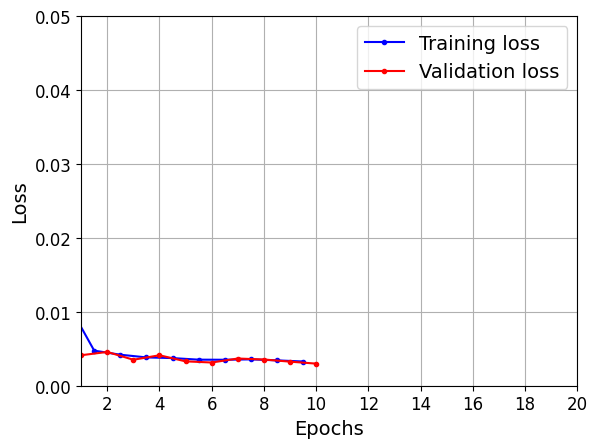

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()


 1/63 [..............................] - ETA: 15s


13/63 [=====>........................] - ETA: 0s 


26/63 [===========>..................] - ETA: 0s


39/63 [=================>............] - ETA: 0s


52/63 [=======================>......] - ETA: 0s


63/63 [==============================] - 1s 4ms/step


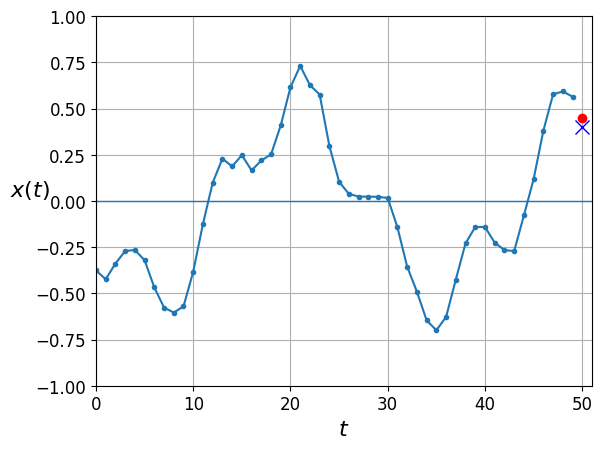

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [24]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]


1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step


In [25]:
Y_pred.shape

(1, 10, 1)

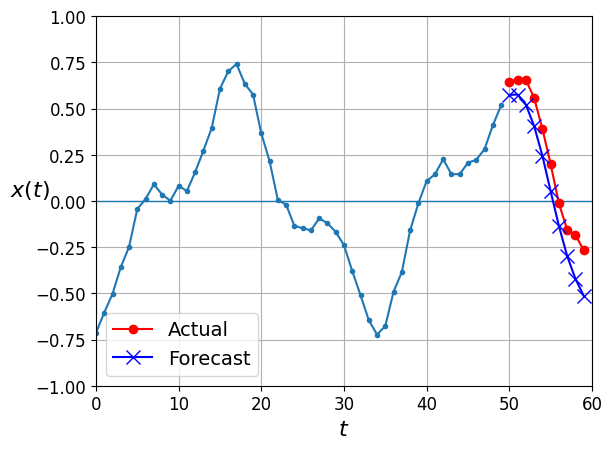

In [26]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [27]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [ ]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [29]:
Y_pred.shape

(2000, 10)

In [30]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.041634984

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [31]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001)
model.compile(loss="mse", optimizer=optimizer)

In [ ]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Now let's create an RNN that predicts all 10 next values at once:

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001)
model.compile(loss="mse", optimizer=optimizer)

In [ ]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [36]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]


1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 182ms/step


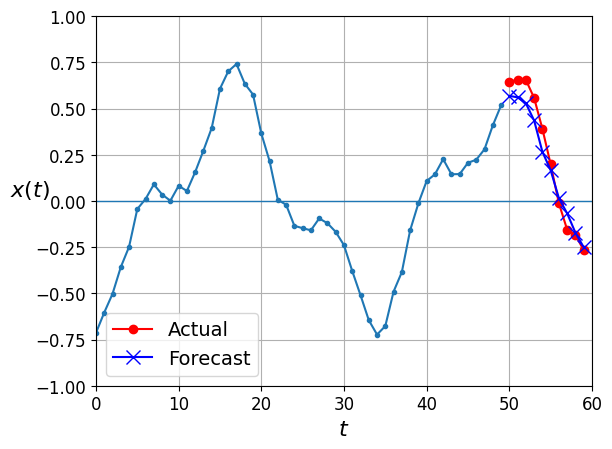

In [37]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [38]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [39]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [40]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.legacy.Adam(learning_rate=0.01), metrics=[last_time_step_mse])

In [ ]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [42]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]


1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 189ms/step


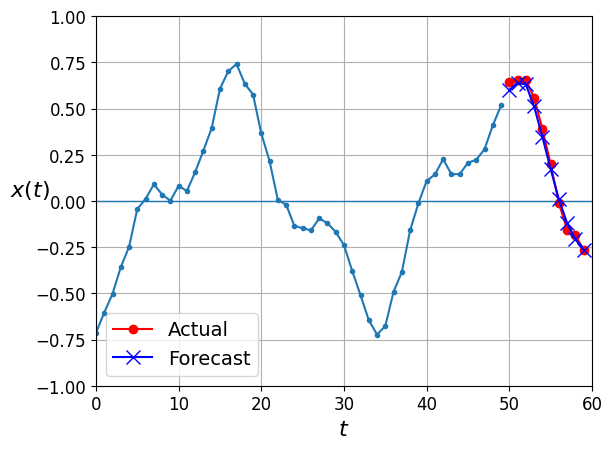

In [43]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Example 

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture20_Images/frenchenglish.jpeg" alt="Drawing" style="width: 900px;"/>

Note that: 
* English sentences are reversed before they are fed to the encoder. For example “I drink milk” is reversed to “milk drink I.” This ensures that the beginning of the English sentence will be fed last to the encoder, which is useful because that’s generally the first thing that the decoder needs to translate.
* Each word is initially represented by a simple integer identifier (e.g., 288 for the word “milk”).
* At each step, the decoder outputs a score for each word in the output vocabulary (i.e., French), and then the Softmax layer turns these scores into probabilities.

* At inference time (after training), you will not have the target sentence to feed to the decoder. Instead, simply feed the decoder the word that it output at the previous step (this requires an embedding lookup that is not shown on the diagram).

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture20_Images/inference.jpeg" alt="Drawing" style="width: 900px;"/>




## No Exercise! 

* Instead go through these slides and understand the functionality 
* Also read and look at examples here: https://www.tensorflow.org/tutorials/recurrent